In [1]:
from pathlib import Path
import pandas
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import tarfile
import pandas as pd

In [2]:
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

In [3]:
housing_full.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

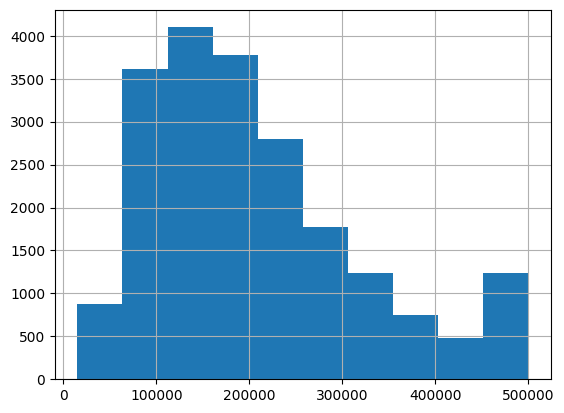

In [4]:
housing_full['median_house_value'].hist()
plt.show()

In [4]:
import numpy as np

In [5]:
def corr(x,y):
  return x.corr(y)


In [6]:
housing_full.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [7]:
num_attributes=[]
cat_attributes=[]

for col in housing_full.columns:
  if housing_full[col].dtype == 'object':
    cat_attributes.append(col)
  else:
    num_attributes.append(col)

In [8]:
for column in num_attributes:
  print(column,corr(housing_full[column],housing_full['median_house_value']))

longitude -0.045966615117978504
latitude -0.14416027687465924
housing_median_age 0.10562341249320996
total_rooms 0.1341531138065631
total_bedrooms 0.049686180247345925
population -0.024649678888894896
households 0.06584265057005648
median_income 0.6880752079585479
median_house_value 1.0


In [9]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing_full['income_cat'] = pd.cut(housing_full['median_income'],bins=[0.,1.5,3.0,4.5,6.,np.inf],labels=[1,2,3,4,5])

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
splitter=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)

In [13]:
print(splitter)

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.2,
            train_size=None)


In [14]:
for train_index,test_index in splitter.split(housing_full,housing_full['income_cat']):
  strat_train_set=housing_full.loc[train_index]
  strat_test_set=housing_full.loc[test_index]


In [15]:
strat_train_set.shape

(16512, 11)

In [16]:
for set_ in (strat_train_set,strat_test_set):
  set_.drop('income_cat',axis=1,inplace=True)

In [17]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



In [18]:
housing = strat_train_set.drop(columns='median_house_value',axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [19]:
def ratio_columns(X):
  return (X[:,[0]]/X[:,[1]])

In [20]:
def ratio_name(FunctionTransformer,features_name_in):
  return ["ratio"]

In [21]:
def ratio_pipeline():
  return make_pipeline(SimpleImputer(strategy='median'),FunctionTransformer(ratio_columns,feature_names_out=ratio_name),StandardScaler())

In [22]:
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.cluster import KMeans

In [23]:
from sklearn.metrics.pairwise import rbf_kernel

In [24]:
class ClusterSim(BaseEstimator,TransformerMixin):
  def __init__(self,n_clusters=10,gamma=1.0,random_state=42):
    self.n_clusters=n_clusters
    self.gamma=gamma
    self.random_state =random_state

  def fit(self,X,y=None):
    self.KMeans_= KMeans(n_clusters=self.n_clusters, random_state=self.random_state, n_init=10) # Pass random_state as keyword argument
    self.KMeans_.fit(X)
    return self

  def transform(self,X):
    return rbf_kernel(X,self.KMeans_.cluster_centers_,gamma=self.gamma)

  def get_feature_names_out(self,names=None):
    return [f'Cluster {i}' for i in range(self.n_clusters)]

In [25]:
sim= ClusterSim(n_clusters=10,gamma=0.1,random_state=42)

In [26]:
help(np.log)

Help on ufunc:

log = <ufunc 'log'>
    log(x, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature])
    
    Natural logarithm, element-wise.
    
    The natural logarithm `log` is the inverse of the exponential function,
    so that `log(exp(x)) = x`. The natural logarithm is logarithm in base
    `e`.
    
    Parameters
    ----------
    x : array_like
        Input value.
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        Elsewhere, the `out`

In [27]:
log_transformer=FunctionTransformer(np.log,feature_names_out="one-to-one")

In [28]:
log_pipeline = make_pipeline(SimpleImputer(strategy='median'),log_transformer,StandardScaler())

In [29]:
def_num_pipeline = make_pipeline(SimpleImputer(strategy='median'))

In [30]:
from sklearn.compose import ColumnTransformer

In [31]:
from sklearn.preprocessing import OneHotEncoder

In [32]:
encoder=OneHotEncoder()

In [64]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity'],
      dtype='object')

In [33]:
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

In [34]:
preprocessing = ColumnTransformer([
    ("bedrooms_per_room",ratio_pipeline(),["total_bedrooms","total_rooms"]),
     ("rooms_per_household",ratio_pipeline(),["total_rooms","households"]),
      ("pop_density",ratio_pipeline(),["population","households"]),
      ("log",log_pipeline,["total_bedrooms", "total_rooms", "population","households", "median_income"]),
       ("cat",cat_pipeline,cat_attributes),
        ("geo",sim,["latitude","longitude"]),
],remainder=def_num_pipeline)

In [35]:
from sklearn.linear_model import LinearRegression


In [36]:
housing_prepared= preprocessing.fit_transform(housing)

In [37]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median'))]),
                                   transformers=[('bedrooms_per_room',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7eabac3eede0>,
                                                                                       func=<function ra...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('geo', ClusterSim(gamma=0.1),
                                                  ['latitude', 'longitude'])])),
                ('linearregression', LinearRegression())])

In [38]:
strat_test_set.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

In [39]:
housing_test= strat_test_set.drop(columns='median_house_value',axis=1)
housing_test_labels=strat_test_set['median_house_value'].copy()

In [42]:
from sklearn.metrics import root_mean_squared_error

In [40]:
    housing_test_pred =lin_reg.predict(housing_test)

In [43]:
final_rmse=root_mean_squared_error(housing_test_labels,housing_test_pred)

In [44]:
final_rmse

74847.2062894188

In [53]:
preprocessing.get_feature_names_out()

array(['bedrooms_per_room__ratio', 'rooms_per_household__ratio',
       'pop_density__ratio', 'log__total_bedrooms', 'log__total_rooms',
       'log__population', 'log__households', 'log__median_income',
       'cat__ocean_proximity_<1H OCEAN', 'cat__ocean_proximity_INLAND',
       'cat__ocean_proximity_ISLAND', 'cat__ocean_proximity_NEAR BAY',
       'cat__ocean_proximity_NEAR OCEAN', 'geo__Cluster 0',
       'geo__Cluster 1', 'geo__Cluster 2', 'geo__Cluster 3',
       'geo__Cluster 4', 'geo__Cluster 5', 'geo__Cluster 6',
       'geo__Cluster 7', 'geo__Cluster 8', 'geo__Cluster 9',
       'remainder__housing_median_age'], dtype=object)

In [54]:
housing_prepared.shape

(16512, 24)

In [55]:
from sklearn.metrics import root_mean_squared_error

In [56]:
linreg_rmse=root_mean_squared_error(housing_labels,lin_reg.predict(housing))

In [57]:
linreg_rmse

67647.0537070821

In [59]:
lin_reg

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median'))]),
                                   transformers=[('bedrooms_per_room',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7eccbaefe980>,
                                                                                       func=<function ra...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('geo', ClusterSim(gamma=0.1),
                                                  ['latitude', 'longitude'])])),
                ('linearregression', LinearRegression())])

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                SimpleImputer(strategy='median'))]),
                     transformers=[('bedrooms_per_room',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('functiontransformer',
                                                     FunctionTransformer(feature_names_out=<function ratio_name at 0x7eccbaefe980>,
                                                                         func=<function ratio_columns at 0x7eccbaefe840>)),
                                                    ('stan...
                                                                         func=<ufunc 'log'>)),
                                                    ('standardscaler',
                         

In [62]:
from sklearn.model_selection import cross_val_score


In [63]:
linreg_rmse = -cross_val_score(lin_reg,housing,housing_labels,scoring="neg_root_mean_squared_error",cv=10)

In [64]:
pd.Series(linreg_rmse).describe()

,0
count,10.000000
mean,68873.664931
std,4116.038025
min,65063.438229
25%,67125.497739
50%,67469.458931
75%,68859.917797
max,79930.814275


In [65]:
from sklearn.ensemble import RandomForestRegressor

rfregressor= make_pipeline(preprocessing,RandomForestRegressor())
rfrmse =-cross_val_score(rfregressor,housing,housing_labels,scoring="neg_root_mean_squared_error",cv=10)

In [68]:
pd.Series(rfrmse).describe()

,0
count,10.000000
mean,46888.365809
std,1070.305740
min,45634.893811
25%,46214.977195
50%,46856.260769
75%,47151.458994
max,49364.301569


In [69]:
from sklearn.model_selection import GridSearchCV

In [88]:
from sklearn.pipeline import Pipeline

In [89]:
full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median'))]),
                                                          transformers=[('bedrooms_per_room',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<function ratio_name at 0x7eccba...
                                                                         ['ocean_proximity']),
                                                                        ('geo',
                                                                         ClusterSim(gamma=0.1),
                                                                         ['latitude',
                                                                          'longitude'])])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [90]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

In [92]:
df=pd.DataFrame(grid_search.cv_results_)

In [93]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.826521,0.283248,0.214615,0.013005,5,4,"{'preprocessing__geo__n_clusters': 5, 'random_...",-46221.795608,-46096.040585,-47406.706682,-46574.847625,590.449377,13
1,8.509768,0.936629,0.185142,0.004761,5,6,"{'preprocessing__geo__n_clusters': 5, 'random_...",-46417.214517,-46570.795227,-47847.149561,-46945.053102,640.952560,14
2,10.357541,0.077737,0.215144,0.004830,5,8,"{'preprocessing__geo__n_clusters': 5, 'random_...",-46928.012056,-46979.789177,-48000.184050,-47302.661761,493.675484,15
3,5.832911,0.259244,0.202451,0.020745,8,4,"{'preprocessing__geo__n_clusters': 8, 'random_...",-44217.955472,-44414.877775,-45475.779447,-44702.870898,552.410063,7
4,8.366235,0.108268,0.194472,0.007111,8,6,"{'preprocessing__geo__n_clusters': 8, 'random_...",-44511.945835,-44821.306472,-45502.724926,-44945.325745,413.881132,10
5,10.766049,0.082464,0.178423,0.002827,8,8,"{'preprocessing__geo__n_clusters': 8, 'random_...",-45125.480059,-45200.265824,-45954.800956,-45426.848946,374.564833,11
6,6.206946,0.517386,0.181948,0.002438,10,4,"{'preprocessing__geo__n_clusters': 10, 'random...",-43524.447820,-43988.221125,-45331.017819,-44281.228921,766.078311,3
7,8.323521,0.163805,0.210021,0.024175,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-43777.659156,-44310.262109,-44950.625235,-44346.182166,479.534527,4
8,10.928431,0.030155,0.182731,0.002830,10,8,"{'preprocessing__geo__n_clusters': 10, 'random...",-44478.343859,-44706.472611,-45330.876760,-44838.564410,360.360254,8
9,8.406223,0.254480,0.205372,0.036832,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-43777.659156,-44310.262109,-44950.625235,-44346.182166,479.534527,4


In [99]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [100]:
random_pipeline =Pipeline([("preprocessing",preprocessing),("random_forest",RandomForestRegressor())],)

In [104]:
random_search_params = {
    'preprocessing__geo__n_clusters': randint(5, 10),
     'random_forest__max_features': randint(4, 8)
}

In [105]:
rdsearchcv = RandomizedSearchCV(random_pipeline, random_search_params, cv=3,
                           scoring='neg_root_mean_squared_error')

In [106]:
rdsearchcv.fit(housing,housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median'))]),
                                                                transformers=[('bedrooms_per_room',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x...
                                                                               ['latitude',
                                                                                'longitude'])])),
                                             ('random_forest',
                                              RandomForestRegressor())]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eccb280ff10>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eccb280fe10>},
                   scoring='neg_root_mean_squared_error')

In [107]:
rdsearchcv.best_params_

{'preprocessing__geo__n_clusters': 7, 'random_forest__max_features': 4}

In [109]:
pd.DataFrame(rdsearchcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.480426,0.172200,0.224556,0.026223,7,7,"{'preprocessing__geo__n_clusters': 7, 'random_...",-45023.264593,-45256.001745,-46278.560437,-45519.275592,545.238023,6
1,6.005291,0.343433,0.215839,0.020630,7,4,"{'preprocessing__geo__n_clusters': 7, 'random_...",-44457.617397,-45271.728838,-45945.270005,-45224.872080,608.234734,1
2,8.235544,0.536560,0.201639,0.014066,5,6,"{'preprocessing__geo__n_clusters': 5, 'random_...",-46431.991775,-46450.057635,-47457.051262,-46779.700224,479.016294,9
3,5.857200,0.192435,0.245612,0.049024,7,4,"{'preprocessing__geo__n_clusters': 7, 'random_...",-44866.648295,-44851.946990,-45976.674846,-45231.756710,526.770857,2
4,8.870337,0.587973,0.229292,0.035572,7,6,"{'preprocessing__geo__n_clusters': 7, 'random_...",-45113.931591,-45164.470104,-45849.216043,-45375.872579,335.339690,4
5,8.768846,0.614953,0.218388,0.011641,7,6,"{'preprocessing__geo__n_clusters': 7, 'random_...",-44831.840342,-45384.846038,-46102.412127,-45439.699503,520.156926,5
6,7.991540,0.306530,0.210247,0.025963,5,6,"{'preprocessing__geo__n_clusters': 5, 'random_...",-46475.911126,-46206.944628,-47454.338626,-46712.398127,535.999081,8
7,5.712739,0.143084,0.200369,0.012700,6,4,"{'preprocessing__geo__n_clusters': 6, 'random_...",-45399.612204,-45458.856913,-46644.528312,-45834.332476,573.405297,7
8,9.497399,0.330823,0.219267,0.015063,8,7,"{'preprocessing__geo__n_clusters': 8, 'random_...",-45090.368410,-44919.236335,-45787.328167,-45265.644304,375.443814,3
9,7.947604,0.294819,0.228716,0.033334,5,6,"{'preprocessing__geo__n_clusters': 5, 'random_...",-46767.703508,-46653.161257,-47627.595320,-47016.153361,434.876176,10


In [110]:
final_model = rdsearchcv.best_estimator_

In [114]:
feature_importance=final_model['random_forest'].feature_importances_

In [115]:
sorted(zip(feature_importance,final_model['preprocessing'].get_feature_names_out()),reverse=True)

[(np.float64(0.23572101879906546), 'log__median_income'),
 (np.float64(0.10410851742972724), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.07437078569772135), 'pop_density__ratio'),
 (np.float64(0.07247830248202244), 'bedrooms_per_room__ratio'),
 (np.float64(0.06494260181352735), 'rooms_per_household__ratio'),
 (np.float64(0.06226591893081021), 'geo__Cluster 3'),
 (np.float64(0.05908015942691875), 'geo__Cluster 1'),
 (np.float64(0.05384782309958085), 'geo__Cluster 5'),
 (np.float64(0.0523006176103204), 'geo__Cluster 6'),
 (np.float64(0.043031421164798085), 'geo__Cluster 4'),
 (np.float64(0.04245937981559892), 'geo__Cluster 2'),
 (np.float64(0.03632937231501412), 'geo__Cluster 0'),
 (np.float64(0.024715606324824307), 'remainder__housing_median_age'),
 (np.float64(0.013978698919132176), 'cat__ocean_proximity_<1H OCEAN'),
 (np.float64(0.013787983363385695), 'log__total_rooms'),
 (np.float64(0.013305823861485065), 'log__population'),
 (np.float64(0.01199151272683859), 'log__households'),


In [116]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_predictions = final_model.predict(X_test)

final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)  # prints 41448.084299370465

44473.19277037502


In [125]:
from sklearn.svm import SVR

In [126]:
svc_pipeline =Pipeline([("preprocessing",preprocessing),("svr",SVR())],)

In [127]:
svc_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median'))]),
                                   transformers=[('bedrooms_per_room',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7eccbaefe980>,
                                                                                       func=<function ratio_...
                                                                                       func=<ufunc 'log'>)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ocean_proximity']),
                                                 ('geo', ClusterSim(gamma=0.1),
                                                  ['latitude', 'longitude'])])),
                ('svr', SVR())])

In [128]:
random_search_params = {
    'preprocessing__geo__n_clusters': randint(5, 10),
     'svr__kernel': ['rbf','linear'],
    'svr__C':randint(1,5)
}

In [129]:
rs_svr =RandomizedSearchCV(svc_pipeline, random_search_params, cv=3,
                           scoring='neg_root_mean_squared_error')

In [130]:
rs_svr.fit(housing,housing_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median'))]),
                                                                transformers=[('bedrooms_per_room',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function ratio_name at 0x...
                                                                               ClusterSim(gamma=0.1),
                                                                               ['latitude',
                                                                                'longitude'])])),
                                             ('svr', SVR())]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eccb30a0ad0>,
                                        'svr__C': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7eccb28c0990>,
                                        'svr__kernel': ['rbf', 'linear']},
                   scoring='neg_root_mean_squared_error')

In [131]:
pd.DataFrame(rs_svr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_svr__C,param_svr__kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.883021,0.566688,1.732963,0.041960,9,3,linear,"{'preprocessing__geo__n_clusters': 9, 'svr__C'...",-105712.963225,-104023.891012,-104487.171461,-104741.341899,712.597686,3
1,6.380916,0.466944,1.824161,0.359761,7,1,linear,"{'preprocessing__geo__n_clusters': 7, 'svr__C'...",-113736.647298,-111757.528180,-112268.556829,-112587.577435,838.871755,6
2,6.197520,0.615456,1.915408,0.494769,7,2,linear,"{'preprocessing__geo__n_clusters': 7, 'svr__C'...",-109361.238658,-107520.338426,-108007.723829,-108296.433638,778.778287,5
3,8.012162,0.039469,4.808961,0.022922,7,4,rbf,"{'preprocessing__geo__n_clusters': 7, 'svr__C'...",-119712.840193,-117614.583650,-117871.343764,-118399.589203,934.506131,8
4,8.194793,0.409361,3.800981,0.235078,5,1,rbf,"{'preprocessing__geo__n_clusters': 5, 'svr__C'...",-119776.034283,-117695.856186,-117940.911500,-118470.933989,928.252160,10
5,6.267220,0.500579,1.717080,0.308507,6,3,linear,"{'preprocessing__geo__n_clusters': 6, 'svr__C'...",-105775.478084,-104089.186265,-104498.986232,-104787.883527,718.095286,4
6,9.013777,0.056687,3.885486,0.005993,8,4,rbf,"{'preprocessing__geo__n_clusters': 8, 'svr__C'...",-119712.561386,-117614.497943,-117871.178935,-118399.412755,934.430585,7
7,8.989285,0.059012,3.882578,0.015624,8,3,rbf,"{'preprocessing__geo__n_clusters': 8, 'svr__C'...",-119739.303675,-117651.042654,-117889.131127,-118426.492485,933.372539,9
8,6.004157,0.563411,1.937607,0.627316,6,4,linear,"{'preprocessing__geo__n_clusters': 6, 'svr__C'...",-102682.591230,-101251.665074,-101516.800067,-101817.018790,621.549610,1
9,6.416799,0.601594,1.504110,0.019334,6,4,linear,"{'preprocessing__geo__n_clusters': 6, 'svr__C'...",-102682.591230,-101251.665074,-101516.800067,-101817.018790,621.549610,1
